# Study 2 - Appeals to emotion and logic

## Polarity analysis

#### SiEBERT Model for polarity

In [1]:
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats

# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/abcnews_transcript.txt', 'r') as file:
    data = file.read()

trumps_responses = []
kamalas_responses = []

trump_identifier = "FORMER PRESIDENT DONALD TRUMP: "
kamala_identifier = "VICE PRESIDENT KAMALA HARRIS: "

for line in data.split('\n'):
    if line.startswith(trump_identifier):
        trumps_responses.append(line[len(trump_identifier):])
    elif line.startswith(kamala_identifier):
        kamalas_responses.append(line[len(kamala_identifier):])

In [3]:
gpu_id = 1

# Model for sentiments: siebert/sentiment-roberta-large-english
# with 0 is negative, 1 is positive
with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
    model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english").to(torch.device("cuda:"+str(gpu_id)))

# Function to classify the sentiment of each sentence
def classify_sentiment_sentence(responses):
    sentence_sentiments = {}
    for response in tqdm(responses):
        sentences = re.split(r'[.!?]', response)
        sentiment_scores = []
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                sentiment_scores.append(sentiment)       
        sentence_sentiments[response] = (sum(sentiment_scores) / len(sentiment_scores), np.std(sentiment_scores))
    return sentence_sentiments

# Function to classify the sentiment of each sentence
def classify_sentiment_all_sentences(responses):
    all_sentence_sentiments = []
    for response in tqdm(responses):
        sentences = re.split(r'[.!?]', response)
        sentiment_scores = []
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                print(sentence)
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                sentiment_scores.append(sentiment)       
        all_sentence_sentiments.extend(sentiment_scores) 
    return all_sentence_sentiments

def classify_sentiment_response(responses):
    sentence_sentiments = {}
    for response in tqdm(responses):
        inputs = tokenizer(response, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        with torch.no_grad():
            logits = model(**inputs).logits
        sentiment = torch.argmax(logits, dim=1).item()   
        sentence_sentiments[response] = (sentiment, 0)
    return sentence_sentiments

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Testing the model on examples

In [4]:
test_responses = [
    "I love this product. It's amazing! Highly recommended.",  # Positive
    "This is the worst experience I've ever had. Completely terrible.",  # Negative
    "The service was okay. Nothing special, but not bad either.",  # Neutral
    "I was impressed by the quality. The customer service was great too.",  # Positive
    "It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.",  # Mixed (partially positive and negative)
    ]

# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_sentence(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

print()
# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_response(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0.0, 0.0)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (0.5, 0.5)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (0.3333333333333333, 0.4714045207910317)
--------------------------------------------------



100%|██████████| 5/5 [00:00<00:00, 68.45it/s]

Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0, 0)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (0, 0)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (1, 0)
--------------------------------------------------


In [5]:
# We need the indices of the responses through the entire debate
indexed_responses = {idx: line for idx, line in enumerate(data.split('\n')) if line}

#### Run polarity classification

In [6]:
trumps_sentiments = classify_sentiment_sentence(trumps_responses)
harris_sentiments = classify_sentiment_sentence(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


In [7]:
# Print sentiments of the first 5 responses and sentences
for sentence, sentiment in trumps_sentiments.items():
    print(sentiment, sentence)

(1.0, 0.0) Nice to see you. Have fun.
(1.0, 0.0) Thank you.
(0.35135135135135137, 0.47739247926096473) First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. We were at 21%. But 

In [8]:
# Write a function that increments a value for each negative sentence in a response and 
# increments another value for each positive sentence in a response
# The function should return the number of positive and negative sentences in a response

def count_positive_negative_sentences(responses):
    positive_sentences = []
    negative_sentences = []
    for response in tqdm(responses):
        pos_values = 0
        neg_values = 0
        sentences = re.split(r'[.!?]', response)
        for sentence in sentences:
            if sentence == '':
                continue
            else:
                inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
                with torch.no_grad():
                    logits = model(**inputs).logits
                sentiment = torch.argmax(logits, dim=1).item()
                if sentiment == 0:
                    neg_values += 1
                elif sentiment == 1:
                    pos_values += 1
        positive_sentences.append(pos_values)
        negative_sentences.append(neg_values)
    return positive_sentences, negative_sentences


posT, negT = count_positive_negative_sentences(trumps_responses)
posK, negK = count_positive_negative_sentences(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


#### Trump's 5 most positive and 5 most negative responses

In [9]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(posT)[-5:]
most_negative_idx = np.argsort(negT)[-5:]

print("Most Positive Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()

print("\nMost Negative Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()
    

Most Positive Responses:
Response 2: First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. We were at 21%. But that's being generous because many things are 50, 60, 70, and 80% 

#### Harris' 5 most positive and 5 most negative responses

In [10]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(posK)[-5:]
most_negative_idx = np.argsort(negK)[-5:]

print("Most Positive Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {kamalas_responses[idx]}")
    print()

print("\nMost Negative Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {kamalas_responses[idx]}")
    print()
    

Most Positive Responses:
Response 22: Well, let's understand how we got here. On Oct. 7, Hamas, a terrorist organization, slaughtered 1,200 Israelis. Many of them young people who were simply attending a concert. Women were horribly raped. And so absolutely, I said then, I say now, Israel has a right to defend itself. We would. And how it does so matters. Because it is also true far too many innocent Palestinians have been killed. Children, mothers. What we know is that this war must end. It must when, end immediately, and the way it will end is we need a cease-fire deal and we need the hostages out. And so we will continue to work around the clock on that. Work around the clock also understanding that we must chart a course for a two-state solution. And in that solution, there must be security for the Israeli people and Israel and in equal measure for the Palestinians. But the one thing I will assure you always, I will always give Israel the ability to defend itself, in particular as 

In [11]:
indexed_sentiments = {}
for idx, response in indexed_responses.items():
    if not response:
        continue
    response = response.split(": ")[1]
    if response in trumps_sentiments:
        indexed_sentiments[idx] = "T", trumps_sentiments[response]
    elif response in harris_sentiments:
        indexed_sentiments[idx] = "H", harris_sentiments[response]


#### Visualise polarity scores 

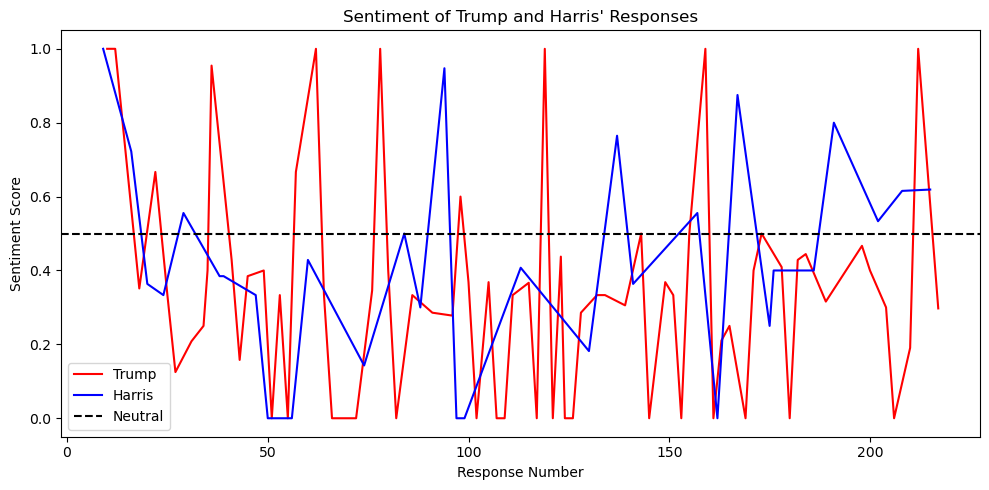

In [12]:
trump_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
trump_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
harris_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]
harris_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_sents, color='red', label="Trump")
ax.plot(harris_indices, harris_sents, color='blue', label="Harris")
# line at 1 for neutral
ax.axhline(.5, color='black', linestyle='--', label='Neutral')
ax.set_title("Sentiment of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Sentiment Score")
ax.legend()
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
#plt.savefig('../figures/subjectivity_plot.png', dpi=300)
plt.show()


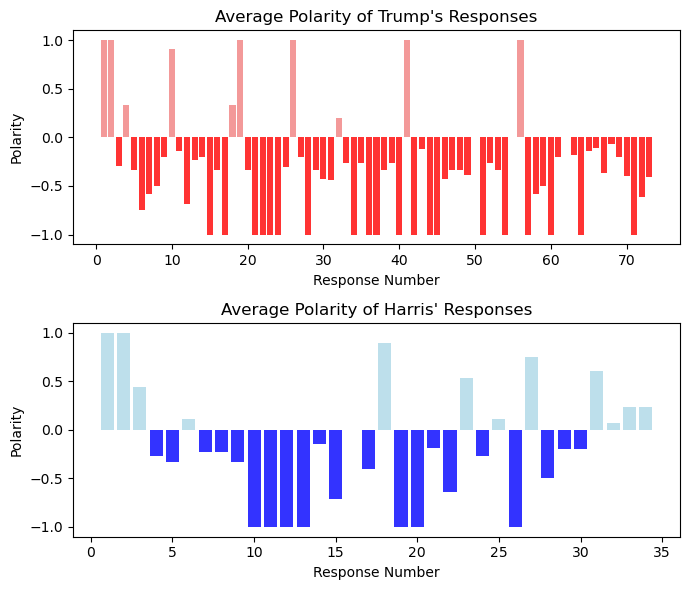

In [13]:
# Adjust the sentiment scores to be between -1 and 1
trumps_sentiments_adj = {idx: (2 * sentiment[0] - 1, sentiment[1]) for idx, sentiment in trumps_sentiments.items()}
harris_sentiments_adj = {idx: (2 * sentiment[0] - 1, sentiment[1]) for idx, sentiment in harris_sentiments.items()}

#trumps_sentiments_adj = trumps_sentiments
#harris_sentiments_adj = harris_sentiments

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in trumps_sentiments_adj.values()]
colors = ['red' if sentiment < 0 else 'lightcoral' for sentiment in y]
axs[0].bar(x, y, color=colors, alpha=.8)
axs[0].set_title('Average Polarity of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Polarity')

N = len(harris_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in harris_sentiments_adj.values()]
colors = ['blue' if sentiment < 0 else 'lightblue' for sentiment in y]
axs[1].bar(x, y, color=colors, alpha=.8)
axs[1].set_title('Average Polarity of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Polarity')
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/polarity_bars.png', dpi=300)
plt.show()





## Subjectivity Analysis

### Using SpaCy TextBlob

In [14]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
print(doc._.blob.polarity)                            # Polarity: -0.125
print(doc._.blob.subjectivity)                        # Subjectivity: 0.9       

-0.125
0.9


In [15]:
def average_sentiment(sentences, nlp):
    sentences = re.split(r'[.!?]', sentences)
    
    if len(sentences) == 1:
        doc = nlp(sentences[0])
        return doc._.blob.polarity, doc._.blob.subjectivity
    
    else:
        polarity = 0
        subjectivity = 0
        for sentence in sentences:
            doc = nlp(sentence)
            polarity += doc._.blob.polarity
            subjectivity += doc._.blob.subjectivity
        return polarity/len(sentences), subjectivity/len(sentences)
    
def sentence_sentiment(responses, nlp):
    all_sentences = []
    all_polarity = []
    all_subjectivitty = []
    for response in responses:
        response = re.split(r'[.!?]', response)
        all_sentences += response
    
    for sentence in all_sentences:
        doc = nlp(sentence)
        all_polarity.append(doc._.blob.polarity)
        all_subjectivitty.append(doc._.blob.subjectivity)

    return all_polarity, all_subjectivitty

In [16]:
trumps_sentiments = [average_sentiment(response, nlp) for response in trumps_responses]
kamalas_sentiments = [average_sentiment(response, nlp) for response in kamalas_responses]

trumps_all_polarity, trumps_all_subjectivity = sentence_sentiment(trumps_responses, nlp)
kamalas_all_polarity, kamalas_all_subjectivity = sentence_sentiment(kamalas_responses, nlp)

In [17]:
# Print some examples of trumps responses with their sentiment scores
for i in range(5):
    print(f"Trump Response {i+1}: {trumps_responses[i]}")
    print(f"Sentiment: {trumps_sentiments[i]}\n")

Trump Response 1: Nice to see you. Have fun.
Sentiment: (0.3, 0.39999999999999997)

Trump Response 2: Thank you.
Sentiment: (0.0, 0.0)

Trump Response 3: First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the 

### Most negative and positive sentences / subjective sentences

In [18]:
trumps_sentences = []
for response in trumps_responses:
    response = re.split(r'[.!?]', response)
    trumps_sentences += response

trumps_polarity = [nlp(sentence)._.blob.polarity for sentence in trumps_sentences]

trumps_polarity_sorted = sorted(list(zip(trumps_sentences, trumps_polarity)), key=lambda x: x[1])

print("Five most negative sentences from Trump's responses:")
for sentence, polarity in trumps_polarity_sorted[:5]:
    print(f"Sentence: {sentence} (Polarity: {polarity})")

print("\n------------------------------\n")

kamalas_sentences = []
for response in kamalas_responses:
    response = re.split(r'[.!?]', response)
    kamalas_sentences += response

kamalas_polarity = [nlp(sentence)._.blob.polarity for sentence in kamalas_sentences]

kamalas_polarity_sorted = sorted(list(zip(kamalas_sentences, kamalas_polarity)), key=lambda x: x[1])

print("Five most negative sentences from Kamala's responses:")
for sentence, polarity in kamalas_polarity_sorted[:5]:
    print(f"Sentence: {sentence} (Polarity: {polarity})")

Five most negative sentences from Trump's responses:
Sentence:  Probably the worst in our nation's history (Polarity: -1.0)
Sentence:  They have and she has destroyed our country with policy that's insane (Polarity: -1.0)
Sentence:  They didn't include the worst cities (Polarity: -1.0)
Sentence:  They didn't include the cities with the worst crime (Polarity: -1.0)
Sentence:  She gave all that stuff up, very wrongly, very horribly (Polarity: -1.0)

------------------------------

Five most negative sentences from Kamala's responses:
Sentence:  It's insulting to the women of America (Polarity: -1.0)
Sentence:  Women were horribly raped (Polarity: -1.0)
Sentence:  And on that day, the president of the United States incited a violent mob to attack our nation's Capitol, to desecrate our nation's Capitol (Polarity: -0.8)
Sentence:  Let's remember Charlottesville, where there was a mob of people carrying tiki torches, spewing antisemitic hate, and what did the president then at the time say (

In [19]:
# Print out the three most subjective sentences from Trump's responses
# and the three most subjective sentences from Kamala's responses
# The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

trumps_subjectivity = [nlp(sentence)._.blob.subjectivity for sentence in trumps_sentences]
trumps_subjectivity_sorted = sorted(list(zip(trumps_sentences, trumps_subjectivity)), key=lambda x: x[1], reverse=True)

print("Five most subjective sentences from Trump's responses:")
for sentence, subjectivity in trumps_subjectivity_sorted[:5]:
    print(f"Sentence: {sentence} (Subjectivity: {subjectivity})")

print("\n------------------------------\n")

kamalas_subjectivity = [nlp(sentence)._.blob.subjectivity for sentence in kamalas_sentences]
kamalas_subjectivity_sorted = sorted(list(zip(kamalas_sentences, kamalas_subjectivity)), key=lambda x: x[1], reverse=True)

print("Five most subjective sentences from Kamala's responses:")

for sentence, subjectivity in kamalas_subjectivity_sorted[:5]:
    print(f"Sentence: {sentence} (Subjectivity: {subjectivity})")

    

Five most subjective sentences from Trump's responses:
Sentence: Nice to see you (Subjectivity: 1.0)
Sentence:  Probably the worst in our nation's history (Subjectivity: 1.0)
Sentence:  They're going in violently (Subjectivity: 1.0)
Sentence:  I created one of the greatest economies in the history of our country (Subjectivity: 1.0)
Sentence:  We had the greatest economy (Subjectivity: 1.0)

------------------------------

Five most subjective sentences from Kamala's responses:
Sentence:  Wade as president of the United States, I will proudly sign it into law (Subjectivity: 1.0)
Sentence:  It's insulting to the women of America (Subjectivity: 1.0)
Sentence: Talk about extreme (Subjectivity: 1.0)
Sentence:  So let's talk about what is important in this race (Subjectivity: 1.0)
Sentence: Well let's talk about extreme (Subjectivity: 1.0)


### Statistical test: Polarity and Subjectivity difference

In [20]:
# Analyse the statistical difference in the distribution of sentiment between Trump and Harris
# That is, check whether the sentiment of Trump's responses has a different distribution than Harris' responses
# Make sure to test for a difference of the distributions, which accounts for changes over time

from scipy.stats import ks_2samp

# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(trumps_all_polarity, kamalas_all_polarity)
print(f"Kolmogorov-Smirnov Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(trumps_all_subjectivity, kamalas_all_subjectivity)
print(f"Kolmogorov-Smirnov Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# The kolmorogov-smirnov test is a non-parametric test that compares the distribution of two samples
# The non-parametric test is used because the sentiment scores are not normally distributed 
# which is tested by the Shapiro-Wilk test

print()
from scipy.stats import shapiro

print("Polarity:")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(trumps_all_polarity)
print(f"Shapiro-Wilk Test for Trump's Polarity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(kamalas_all_polarity)
print(f"Shapiro-Wilk Test for Harris' Polarity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# both p-values are less than 0.05, which means that the null hypothesis that the data is normally distributed is rejected
# the sentiment scores are not normally distributed

print("\nSubjectivity:")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(trumps_all_subjectivity)
print(f"Shapiro-Wilk Test for Trump's Subjectivity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(kamalas_all_subjectivity)
print(f"Shapiro-Wilk Test for Harris' Subjectivity:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")



Kolmogorov-Smirnov Test:
Statistic: 0.10187041306115176
P-value: 0.005992149096793954
Kolmogorov-Smirnov Test:
Statistic: 0.1270227077834575
P-value: 0.0002426568452857982

Polarity:
Shapiro-Wilk Test for Trump's Polarity:
Statistic: 0.7414778586585746
P-value: 2.5837275438017716e-35
Shapiro-Wilk Test for Harris' Polarity:
Statistic: 0.7786741444610967
P-value: 8.956689609247559e-23

Subjectivity:
Shapiro-Wilk Test for Trump's Subjectivity:
Statistic: 0.6887499315190861
P-value: 7.879900785383289e-38
Shapiro-Wilk Test for Harris' Subjectivity:
Statistic: 0.7880413101446664
P-value: 2.454731240310645e-22


### Plot Subjectivity (TextBlob)

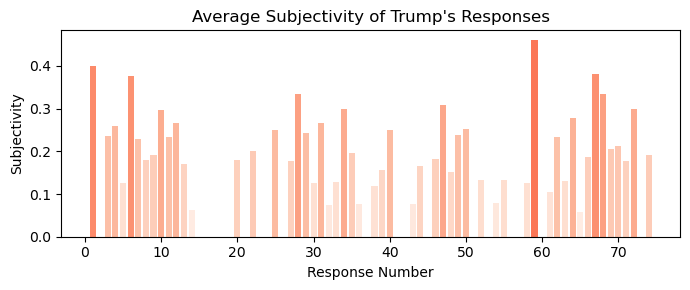

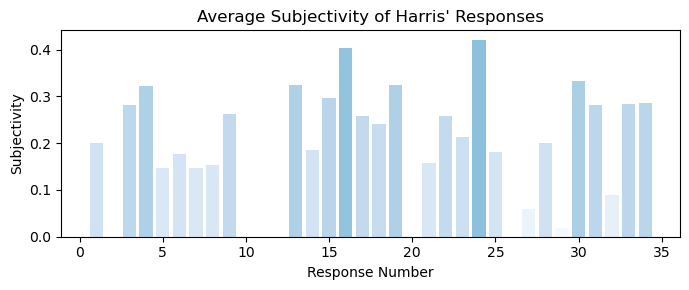

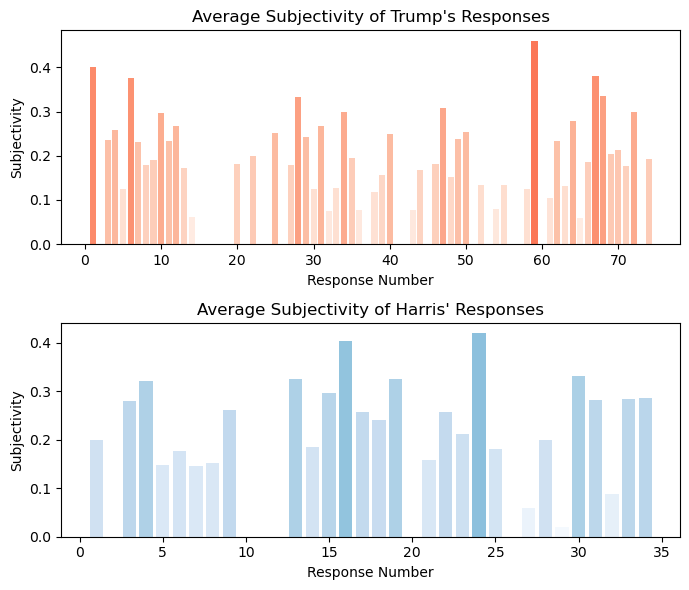

In [21]:
# Plot average subjectivity of trump's responses using a bar plot
# Values closer to 0 are objective, values closer to 1 are subjective
# Bars are continously colored from light red to dark red based on the subjectivity value

N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in trumps_sentiments]
colors = plt.cm.Reds(y)

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Subjectivity of Trump\'s Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Subjectivity')
plt.tight_layout()
plt.show()

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in kamalas_sentiments]
colors = plt.cm.Blues(y)

fig, ax = plt.subplots(figsize=(7, 3))
ax.bar(x, y, color=colors)
ax.set_title('Average Subjectivity of Harris\' Responses')
ax.set_xlabel('Response Number')
ax.set_ylabel('Subjectivity')
plt.tight_layout()
plt.show()

# Now, plot both trumps and kamalas responses in two subplots of the same figure
# Make sure the colors are consistent with the previous plots

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in trumps_sentiments]
colors = plt.cm.Reds(y)
axs[0].bar(x, y, color=colors)
axs[0].set_title('Average Subjectivity of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Subjectivity')

N = len(kamalas_sentiments)
x = np.arange(1, N + 1)
y = [sentiment[1] for sentiment in kamalas_sentiments]
colors = plt.cm.Blues(y)
axs[1].bar(x, y, color=colors)
axs[1].set_title('Average Subjectivity of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Subjectivity')

plt.tight_layout()
# store the plot in the figure folder in 300 dpi
plt.savefig('../figures/subjectivity_subplots.png', dpi=300)
plt.show()


In [22]:
# Report the mean and standard deviation of the subjectivity scores 
# based on [sentiment[1] for sentiment in trumps_sentiments] and [sentiment[1] for sentiment in kamalas_sentiments]

trumps_all_subjectivity = [float(score) for score in trumps_all_subjectivity]
kamalas_all_subjectivity = [float(score) for score in kamalas_all_subjectivity]

print("\nMean and Standard Deviation of Subjectivity:")
print(f"Trump: Mean: {np.mean(trumps_all_subjectivity)}, Standard Deviation: {np.std(trumps_all_subjectivity)}")
print(f"Harris: Mean: {np.mean(kamalas_all_subjectivity)}, Standard Deviation: {np.std(kamalas_all_subjectivity)}")




Mean and Standard Deviation of Subjectivity:
Trump: Mean: 0.2022172609231595, Standard Deviation: 0.31000521426561095
Harris: Mean: 0.21834822491388148, Standard Deviation: 0.27376044706496694


## Subjectivity: mDeBERTa V3

In [23]:
gpu_id = 1

# Model for subjectivity: GroNLP/mdebertav3-subjectivity-english
# with 0 is objective, 1 is subjective

with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("GroNLP/mdebertav3-subjectivity-english")
    model = AutoModelForSequenceClassification.from_pretrained("GroNLP/mdebertav3-subjectivity-english").to(torch.device("cuda:"+str(gpu_id)))

#### Testing subjectivity rating of model on examples

In [24]:
test_responses = [
    # Sentences with high subjectivity
    "I think this is the best product I've ever bought. It's amazing!",
    "I can't believe how bad this product is. It's terrible!",
    # Sentences with low subjectivity
    "Berlin is the capital of Germany.",
    "The sun rises in the east.",
]

# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_sentence(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

print()
# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment_response(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

100%|██████████| 4/4 [00:00<00:00, 33.18it/s]


Response: 'I think this is the best product I've ever bought. It's amazing!'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'I can't believe how bad this product is. It's terrible!'
Average Sentiment Score: (1.0, 0.0)
--------------------------------------------------
Response: 'Berlin is the capital of Germany.'
Average Sentiment Score: (0.0, 0.0)
--------------------------------------------------
Response: 'The sun rises in the east.'
Average Sentiment Score: (0.0, 0.0)
--------------------------------------------------



100%|██████████| 4/4 [00:00<00:00, 66.77it/s]

Response: 'I think this is the best product I've ever bought. It's amazing!'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'I can't believe how bad this product is. It's terrible!'
Average Sentiment Score: (1, 0)
--------------------------------------------------
Response: 'Berlin is the capital of Germany.'
Average Sentiment Score: (0, 0)
--------------------------------------------------
Response: 'The sun rises in the east.'
Average Sentiment Score: (0, 0)
--------------------------------------------------


In [25]:
trumps_sentiments = classify_sentiment_sentence(trumps_responses)
harris_sentiments = classify_sentiment_sentence(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


In [26]:
# Print sentiments of the first 5 responses and sentences
for sentence, sentiment in trumps_sentiments.items():
    print(sentiment, sentence)


(0.0, 0.0) Nice to see you. Have fun.
(0.0, 0.0) Thank you.
(0.5405405405405406, 0.4983537544482643) First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. We were at 21%. But th

In [27]:
objT, subT = count_positive_negative_sentences(trumps_responses)
objK, subK = count_positive_negative_sentences(kamalas_responses)

100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


In [28]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(subT)[-5:]
most_negative_idx = np.argsort(objT)[-5:]

print("Trump: Most Subjective Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()

print("\nTrump: Most Objective Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()
    

Trump: Most Subjective Responses:
Response 73: So, she just started by saying she's going to do this, she's going to do that, she's going to do all these wonderful things. Why hasn't she done it? She's been there for 3 1/2 years. They've had 3 1/2 years to fix the border. They've had 3 1/2 years to create jobs and all the things we talked about. Why hasn't she done it? She should leave right now, go down to that beautiful white house, go to the capitol, get everyone together and do the things you want to do. But you haven't done it. And you won't do it. Because you believe in things that the American people don't believe in. You believe in things like we're not going to frack. We're not going to take fossil fuel. We're not going to do, things that are going to make this country strong, whether you like it or not. Germany tried that and within one year they were back to building normal energy plants. We're not ready for it. We can't sacrifice our country for the sake of bad vision. But 

In [29]:
# Find index of the 5 most positive and 5 most negative responses
# Print all 5 responses 

most_positive_idx = np.argsort(subK)[-5:]
most_negative_idx = np.argsort(objK)[-5:]

print("Harris: Most Subjective Responses:")
for idx in most_positive_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()

print("\nHarris: Most Objective Responses:")
for idx in most_negative_idx:
    print(f"Response {idx}: {trumps_responses[idx]}")
    print()
    

Harris: Most Subjective Responses:
Response 33: These are not good things for the environment that she understands.

Response 2: First of all, I have no sales tax. That's an incorrect statement. She knows that. We're doing tariffs on other countries. Other countries are going to finally, after 75 years, pay us back for all that we've done for the world. And the tariff will be substantial in some cases. I took in billions and billions of dollars, as you know, from China. In fact, they never took the tariff off because it was so much money, they can't. It would totally destroy everything that they've set out to do. They've taken in billions of dollars from China and other places. They've left the tariffs on. When I had it, I had tariffs and yet I had no inflation. Look, we've had a terrible economy because inflation has -- which is really known as a country buster. It breaks up countries. We have inflation like very few people have ever seen before. Probably the worst in our nation's his

In [30]:
indexed_sentiments = {}
for idx, response in indexed_responses.items():
    if not response:
        continue
    response = response.split(": ")[1]
    if response in trumps_sentiments:
        indexed_sentiments[idx] = "T", trumps_sentiments[response]
    elif response in harris_sentiments:
        indexed_sentiments[idx] = "H", harris_sentiments[response]


### Visualisation of Subjectivity scores

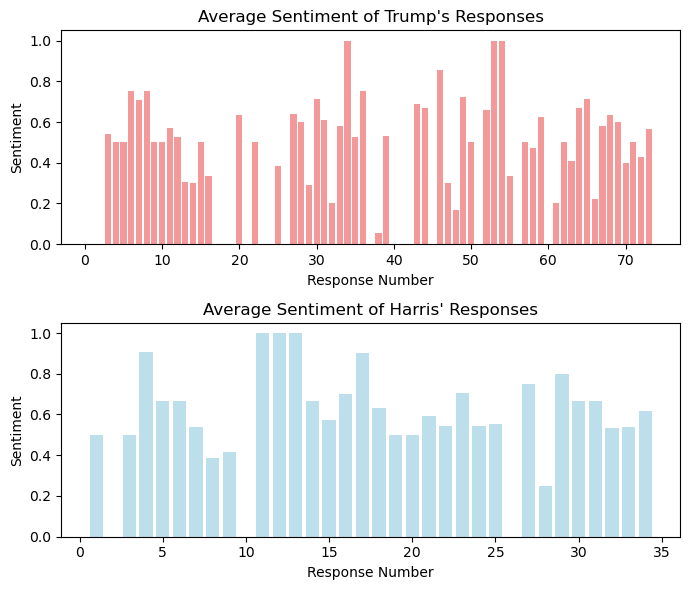

In [31]:
# No linear adjustment is needed for subjectivity scores

trump_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
trump_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
harris_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]
harris_sents = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]

trumps_sentiments_adj = trumps_sentiments
harris_sentiments_adj = harris_sentiments

fig, axs = plt.subplots(2, 1, figsize=(7, 6))
N = len(trumps_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in trumps_sentiments_adj.values()]
colors = ['red' if sentiment < 0 else 'lightcoral' for sentiment in y]
axs[0].bar(x, y, color=colors, alpha=.8)
axs[0].set_title('Average Sentiment of Trump\'s Responses')
axs[0].set_xlabel('Response Number')
axs[0].set_ylabel('Sentiment')

N = len(harris_sentiments_adj)
x = np.arange(1, N + 1)
y = [sentiment[0] for sentiment in harris_sentiments_adj.values()]
colors = ['blue' if sentiment < 0 else 'lightblue' for sentiment in y]
axs[1].bar(x, y, color=colors, alpha=.8)
axs[1].set_title('Average Sentiment of Harris\' Responses')
axs[1].set_xlabel('Response Number')
axs[1].set_ylabel('Sentiment')
plt.tight_layout()
# store the plot in the figure folder in 300 dpi
#plt.savefig('../figures/subjectivity_bars.png', dpi=300)
plt.show()




### Statistical tests for the model results

In [32]:
# 1. Check for normality using the Shapiro-Wilk test (optional)
shapiro_test_list_1 = stats.shapiro(trump_sents)
shapiro_test_list_2 = stats.shapiro(harris_sents)

print(f"Shapiro-Wilk Test for List 1: W={shapiro_test_list_1.statistic}, p-value={shapiro_test_list_1.pvalue}")
print(f"Shapiro-Wilk Test for List 2: W={shapiro_test_list_2.statistic}, p-value={shapiro_test_list_2.pvalue}")

# 2. Perform the Kolmogorov-Smirnov test
ks_test = stats.ks_2samp(trump_sents, harris_sents)
print(f"Kolmogorov-Smirnov Test: D-statistic={ks_test.statistic}, p-value={ks_test.pvalue}")


mann_whitney_test = stats.mannwhitneyu(trump_sents, harris_sents, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={mann_whitney_test.statistic}, p-value={mann_whitney_test.pvalue}")

# Now to the test for the adjusted sentiment scores
adj_trump_sentiments = [sentiment[0] for sentiment in trumps_sentiments_adj.values()]
adj_harris_sentiments = [sentiment[0] for sentiment in harris_sentiments_adj.values()]

# 1. Check for normality using the Shapiro-Wilk test (optional)
shapiro_test_list_1 = stats.shapiro(adj_trump_sentiments)
shapiro_test_list_2 = stats.shapiro(adj_harris_sentiments)

print(f"Shapiro-Wilk Test for List 1: W={shapiro_test_list_1.statistic}, p-value={shapiro_test_list_1.pvalue}")
print(f"Shapiro-Wilk Test for List 2: W={shapiro_test_list_2.statistic}, p-value={shapiro_test_list_2.pvalue}")

# 2. Perform the Kolmogorov-Smirnov test
ks_test = stats.ks_2samp(adj_trump_sentiments, adj_harris_sentiments)
print(f"Kolmogorov-Smirnov Test: D-statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

mann_whitney_test = stats.mannwhitneyu(adj_trump_sentiments, adj_harris_sentiments, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={mann_whitney_test.statistic}, p-value={mann_whitney_test.pvalue}")

Shapiro-Wilk Test for List 1: W=0.9069183351992028, p-value=4.1854057024658354e-05
Shapiro-Wilk Test for List 2: W=0.9216927744247952, p-value=0.020415714693712162
Kolmogorov-Smirnov Test: D-statistic=0.35393939393939394, p-value=0.004512549828309104
Mann-Whitney U Test: U-statistic=758.5, p-value=0.0013390609240422158
Shapiro-Wilk Test for List 1: W=0.9129772247397274, p-value=9.469939983478328e-05
Shapiro-Wilk Test for List 2: W=0.912038181617372, p-value=0.009687932387232815
Kolmogorov-Smirnov Test: D-statistic=0.32232070910556004, p-value=0.011917047198395812
Mann-Whitney U Test: U-statistic=821.0, p-value=0.00480344046777167
